# Predicting the Forum of origin for text data 

---


This notebook shows how to pull [Reddit](https://reddit.com/) 
posts using [PRAW](https://praw.readthedocs.io/en/latest/) in order to 

train a language model that can predict the forum a post originates from.



In [ ]:
# List of subreddits to use as a basis for our model
forums = [
    'astrology',
    'datascience',
    'machinelearning',
    'physics',
    'conspiracy'
]

## The ML Pipeline

### Load data
- Define list of subreddits
- Acquire text data from each subreddit
- Filter posts with less than 100 alphabetic characters

In [1]:
import numpy as np
import config
import praw
import re


def load_data():
    # Create reddit object
    reddit = praw.Reddit(
        client_id = config.id,
        client_secret = config.secret,
        user_agent = 'Reddit Scraper'
    )

    # Count number of alphabetic characters using RegEx substitution
    char_count = lambda post: len(re.sub('\W|\d', '', post.selftext))

    # Condition for filtering the posts
    mask = lambda post: char_count(post) >= 100

    # Lists to hold results
    data = []
    labels = []


    for i, forum in enumerate(forums):

        # Get latest posts from the subreddit
        subreddit_data = reddit.subreddit(forum).new(limit=1000)

        # Filter out posts not satisfying condition
        posts = [post.selftext for post in filter(mask, subreddit_data)]

        # Add posts and labels to respective lists
        data.extend(posts)
        labels.extend([i] * len(posts))

        print(f"Number of posts from r/{forum}: {len(posts)}",
              f"\nSample Post: {posts[0][:600]}...\n",
              "_" * 80 + '\n')
    
    return data, labels

### Partition training and validation data

Hold out some portion of our data in order to
evaluate how our model performs on unseen text.

It is important to do this **as early as possible**

Keep all information about the test set
away from the training data if you want to accurately measure
how your model performs out in the wild

The following parameters allow for our results to be reproduced

- TEST_SIZE: 
    percentage of total data to be held out from training set
    in order to validate our model's performance on unseen data

- RANDOM_STATE:
    an integer corresponding to the random state of our 
    train_test_split function, and can be used to 
    reproduce the data partitions if needed 



In [2]:
from sklearn.model_selection import train_test_split


TEST_SIZE = .2
RANDOM_STATE = 0

def split_data():

    print(f"Partitioning {100*TEST_SIZE}% of data for model evaluation...")
    # Partition training/validation sets
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels,
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE)

    print(f"{len(y_test)} samples selected.")
    
    return X_train, X_test, y_train, y_test


### Preprocessing and feature extraction 

- Remove symbols, numbers, and url-like strings with custom preprocessor 
- vectorize text using term frequency-inverse document frequency
- reduce to principal values using singular value decomposition
- Partition data and labels into training/validation sets

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


MIN_DOC_FREQ = 1
N_COMPONENTS = 1000
N_ITER = 30


def preprocessing_pipeline():

    """Tune the following parameters for efficiency/accuracy

        - MIN_DOC_FREQ: 
            minimum frequency for a term to be used in our model

        - N_COMPONENTS: 
            number of components (words) used in our vectorization,
            larger values may result in higher accuracy, 
            but increases computation time
        - N_ITER:
            number of iterations for the principal component analysis,
            larger values may result in higher accuracy, 
            but increases computation time
        """
    
    # Remove non alphabetic characters and URL-like strings
    pattern = r'\W|\d|http.*\s+|www.*\s+'
    preprocessor = lambda text: re.sub(pattern, ' ', text)

    # tf-idf vectorizer with custom preprocessing function
    vectorizer = TfidfVectorizer(
        preprocessor = preprocessor, 
        stop_words = 'english',
        min_df = MIN_DOC_FREQ)

    # SVD object to combine with vectorizer for latent semantic analysis
    decomposition = TruncatedSVD(
        n_components = N_COMPONENTS,
        n_iter = N_ITER)
    
    pipeline = [('tfidf',vectorizer),
                ('svd',decomposition)]

    return pipeline

### Model selection
Chose a model or set of models that fit your use case.

Here, we've selected three distinct classification models

- KNeighborsClassifier, 
- RandomForestClassifier, 
- and LogisticRegressionCV

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV



N_NEIGHBORS = 4
CV = 3


def load_models():
    """Set the following model parameters

        For 'KNeighborsClassifier'
            N_NEIGHBORS: number of neighbors to be used when predicting

        For 'LogisticRegressionCV'
            CV: number of cross-validations to make when fitting
    """

    model_1 = KNeighborsClassifier(n_neighbors = N_NEIGHBORS)
    model_2 = RandomForestClassifier(random_state = RANDOM_STATE)
    model_3 = LogisticRegressionCV(cv = CV, random_state = RANDOM_STATE)

    models = [("kneighbors", model_1),
              ("forest", model_2),
              ("lrcv", model_3)]
    
    return models

### Fit and Evaluate models

Fit models and evaluate performance on validation set

In [5]:
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline


def fit_and_evaluate(models, pipeline, X_train, X_test, y_train, y_test):
    results = []
    for name, model in models:

        # Pipeline to ensure no information from test set leaks into model
        pipe = Pipeline(pipeline + [(name, model)])

        # Fit to training data
        print(f"Fitting {name} to training data...")
        pipe.fit(X_train, y_train)

        # Predict on test set
        y_pred = pipe.predict(X_test)

        # Get accuracy, precision, recall, f1-score
        report = classification_report(y_test,y_pred)
        print("Classification report\n", report)

        results.append([model, {
            'model': name,
            'predictions': y_pred,
            'report': report,
        }])           

    return results

## Run training/inference for all models

In [6]:

if __name__ == "__main__":
    data, labels = load_data()
    X_train, X_test, y_train, y_test = split_data()
    pipeline = preprocessing_pipeline()
    all_models = load_models()
    results = fit_and_evaluate(all_models, pipeline,
                                X_train, X_test, 
                                y_train, y_test)

print("Success")

Number of posts from r/astrology: 574 
Sample Post: Hey everyone, this is an honest question. Astrology is heavily focused and dependent on the state of the stars in the night sky. But how does this correlate with deep time? In a billion years when the constellations have shifted and changed, perhaps even faded away. Then where is the meaning derived from?

This isn't suppose to "debunk" anyone or anything. I just felt really anxious when I realized that yeah. One day the constellations will be gone....
 ________________________________________________________________________________

Number of posts from r/datascience: 627 
Sample Post:  *Predictive prosecution — data-driven policies that shape prosecution strategies — exists in an experimental phase. This Essay seeks to raise preliminary questions about an obviously nascent experiment. But, the questions are real, and will need to be answered soon. The hope of this brief Essay is to set forth the possible impacts, raise questions, an

/Users/sb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/sb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

Classification report
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       105
           1       0.83      0.77      0.80       130
           2       0.78      0.92      0.85       174
           3       1.00      0.55      0.71        33
           4       0.93      0.88      0.90        72

    accuracy                           0.85       514
   macro avg       0.90      0.81      0.84       514
weighted avg       0.86      0.85      0.85       514

Success


## Visualize Results

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

##### Plotting functions (boring stuff)

In [8]:
def plot_distribution():
    _, counts = np.unique(labels, return_counts=True)
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,3), dpi=120)
    plt.title("Number of posts by forum")
    sns.barplot(x=forums, y=counts)
    plt.legend([' '.join([f.title(),f"- {c} posts"]) 
                for f,c in zip(forums, counts)])
    plt.show()

def plot_confusion(result):
    print("Classification report\n",
          result[-1]['report'])
    y_pred = result[-1]['predictions']
    conf_matrix = confusion_matrix(y_test,y_pred)
    _, test_counts = np.unique(y_test, return_counts=True)
    conf_matrix_percent =\
        conf_matrix / test_counts.transpose() * 100
    plt.figure(figsize=(9,8), dpi=120)
    plt.title(result[-1]['model'].upper() + " Results")
    plt.xlabel("Ground truth")
    plt.ylabel("Model prediction")
    ticklabels = [f"r/{sub}" for sub in forums]
    sns.heatmap(data=conf_matrix_percent, 
                xticklabels = ticklabels,
                yticklabels = ticklabels,
                annot=True, fmt='.2f')
    plt.show()


### Distribution of posts

Examine the number of samples collected from each forum

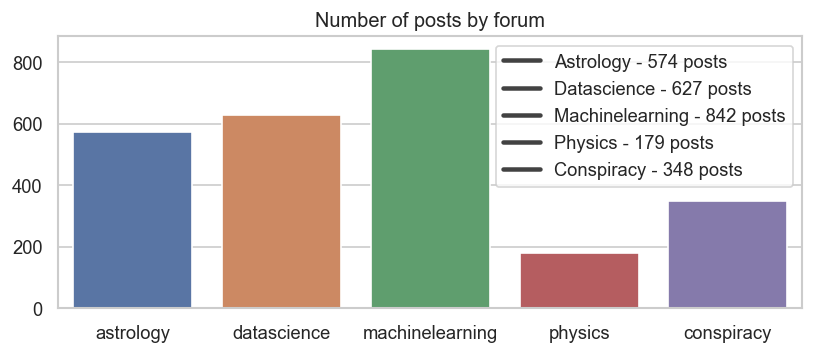

In [9]:
plot_distribution()

### Confusion Matrices

A quick way to visualize the kinds ofpredictions a classifier 
is making is to use a confusion matrix. $\mathbf{C}$

Where $\mathbf{C}_{i,j}$ is the number of times
our model predicted $j$ for class $i$


#### KNeighbors result

Classification report
               precision    recall  f1-score   support

           0       0.70      0.97      0.81       105
           1       0.68      0.79      0.73       130
           2       0.80      0.67      0.73       174
           3       0.84      0.48      0.62        33
           4       0.90      0.62      0.74        72

    accuracy                           0.75       514
   macro avg       0.78      0.71      0.73       514
weighted avg       0.76      0.75      0.74       514



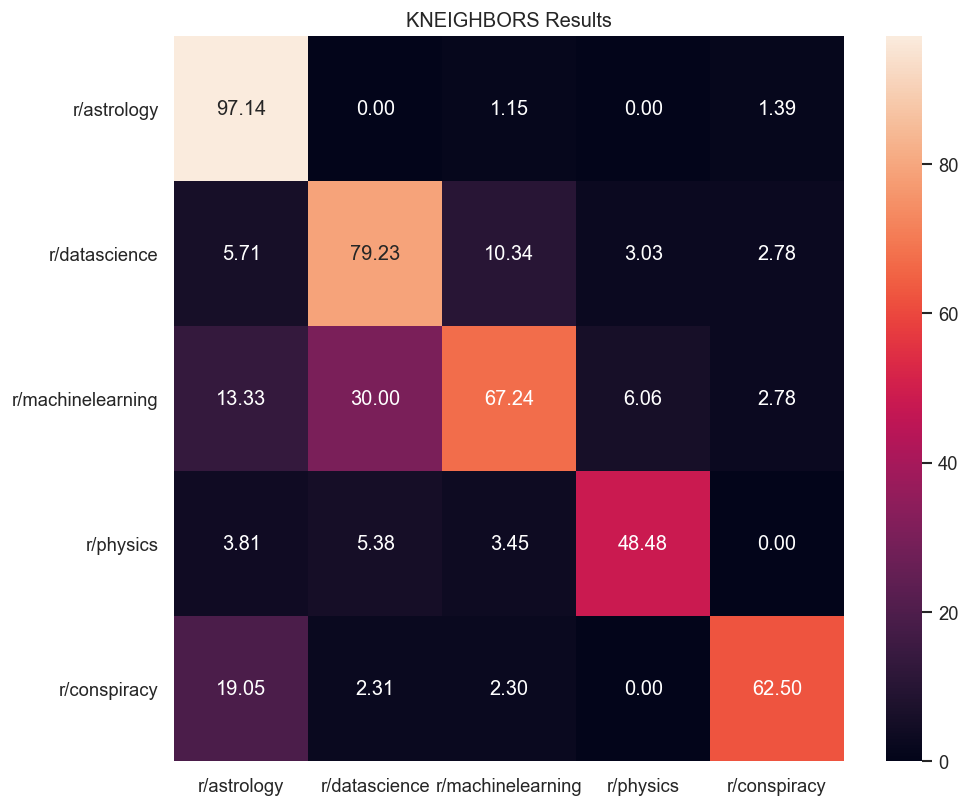

In [10]:
plot_confusion(results[0])

#### RandomForest result

Classification report
               precision    recall  f1-score   support

           0       0.84      0.91      0.88       105
           1       0.82      0.64      0.72       130
           2       0.69      0.93      0.79       174
           3       1.00      0.39      0.57        33
           4       0.96      0.68      0.80        72

    accuracy                           0.78       514
   macro avg       0.86      0.71      0.75       514
weighted avg       0.81      0.78      0.78       514



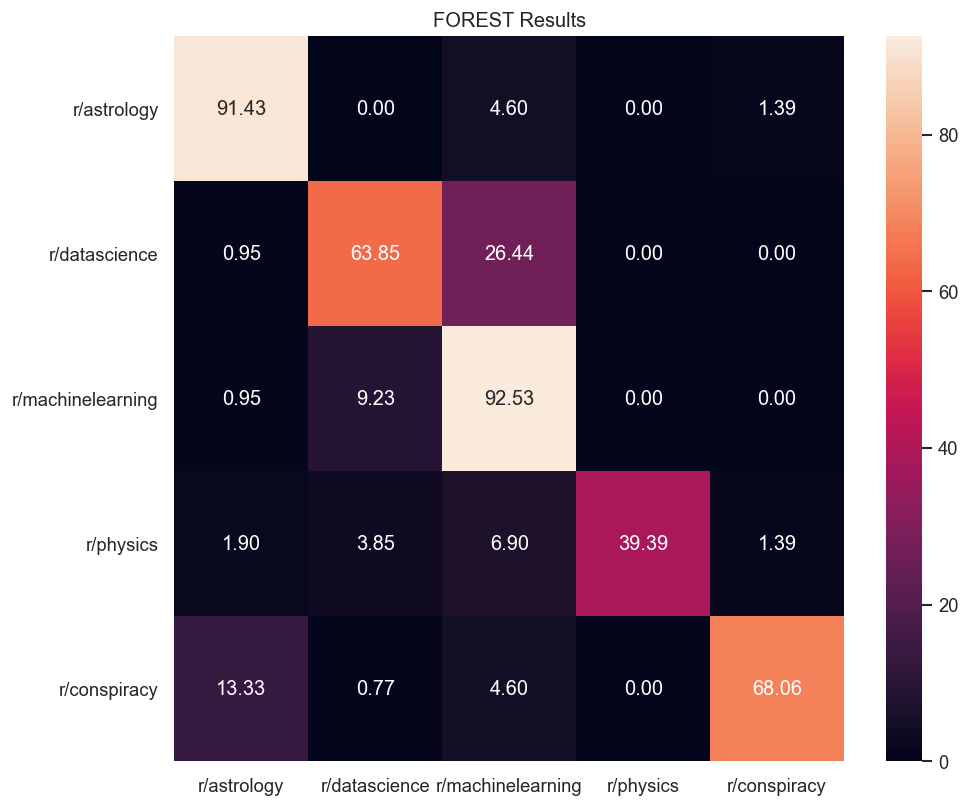

In [11]:
plot_confusion(results[1])

#### LogisticRegressionCV result

Classification report
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       105
           1       0.83      0.77      0.80       130
           2       0.78      0.92      0.85       174
           3       1.00      0.55      0.71        33
           4       0.93      0.88      0.90        72

    accuracy                           0.85       514
   macro avg       0.90      0.81      0.84       514
weighted avg       0.86      0.85      0.85       514



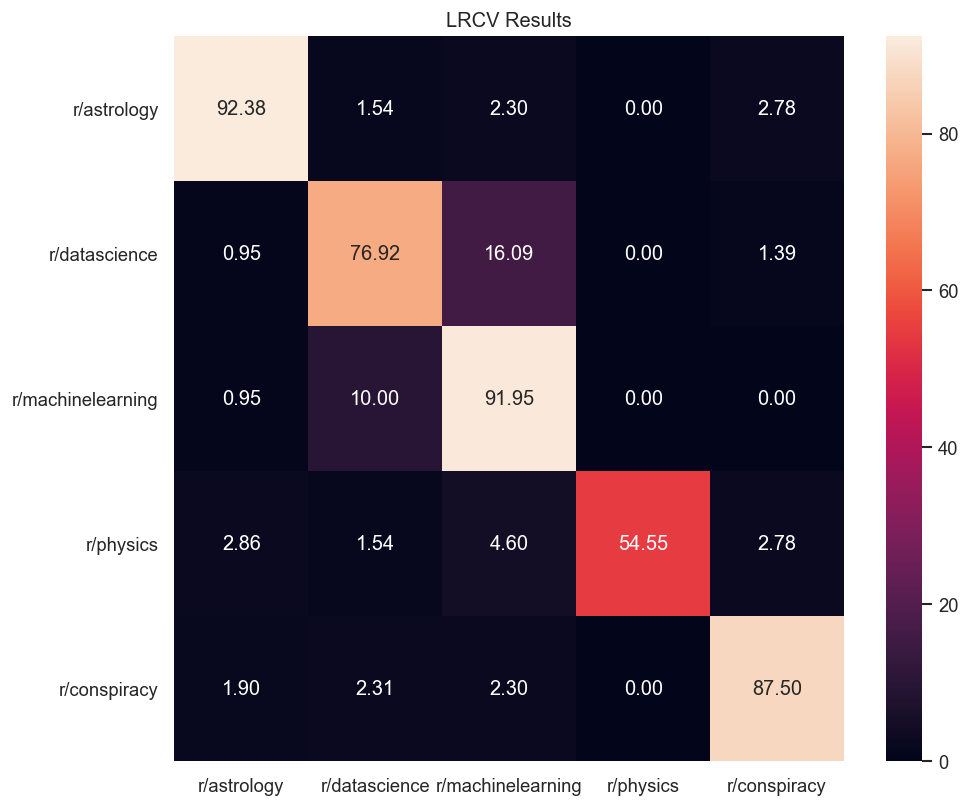

In [12]:
plot_confusion(results[2])